# Market-implied stock price PDFs: risk-neutral and physical

Option prices embed information about the markets expectation of future performance of the underlying asset.
The set of European option prices across strikes for a given maturity $T$ implies a risk-neutral probability density function (details below) of the price $S_T$ of the underlying asset at the maturity.

This density reflects the distribution consistent with current option prices under the pricing measure that discounts payoffs at the risk-free rate.
It also reflects both how the market expects the underlying to move (although it is important to note that the pdf we obtain is NOT simply the market's prediction of where the stock is likely to move), as well as how the market prices risk across the various outcomes.

This project uses several years of daily SPX option chain data to extract the market-implied risk-neutral pdfs for options with 1 day maturities, 7 day maturities, and 28 day maturities.
Using the Breeden-Litzenberger relation, which says that the implied pdf is given by the second partial derivative of price at maturity with respect to strike:
$$ f_Q(K) = e^{rT} \frac{\partial^2 C(K, T)}{\partial K^2},$$
we numerically recover the pdf.
Since strikes come in discrete increments, we require some numerical techniques to interpolate.
We also need to smooth the data enough to take a second derivative.

I then discuss and compare ways of recovering the real-world probability distribution from the risk-neutral one.

There are two main goals of this project:
1. Compare the risk-neutral pdf to the realized price distribution.
2. Test a simple way of estimating the real-world density function from the risk-neutral density.

The secondary goal is to give exposition of the theory and background needed to understand this topic so that a wider audience may find it useful and engaging.


## Part 1: risk-neutral distributions

### Theoretical Background

#### Risk-neutral probability measure

#### The Breeden-Litzenberger Formula
Recall that the fair value of a call option with time $\tau$ until expiry is the present value of the expected payoff.
If $f_Q$ denotes the PDF of the stock prices $S_T$ of some stock $S$ at time $T$ (with respect to the risk-neutral measure $Q$), this is
$$
\begin{align*}
C(K, \tau) &= e^{-rt} \mathbb E_Q(\max\{S_T - K, 0\}) \\
&= e^{-rt} \int_0^\infty \max\{x - K, 0\} f_Q(x) \, d x \\
&= e^{-rt} \int_K^\infty (x - K) f(x) \, dx.
\end{align*}
$$
To derive the Breeden-Litzenberger formula, we just need to invert this to find $f$ as a function of $C$.
Taking the partial derivative with respect to $K$ gives
$$
\begin{align*}
\frac{\partial C}{\partial K} &= - e^{-rt} \int_{K}^\infty f(x) \, dx \\
&= e^{-rt} \left( \int_{-\infty}^K f(x) \, dx - 1 \right),
\end{align*}
$$
where in the second step we use the fact that $\int_{\R} f(x) \, dx = 1$.
But now we can find $f$ by taking one more derivative.
Doing this and rearranging, we see that
$$f(K) = e^{rt} \frac{\partial^2 C}{\partial K^2}.$$

### Implementation

#### The data

I obtained my options chain data from OptionsDX.
I have EOD options chain data for SPX for years 2020 through 2023.
I filtered for options with 1 day maturities, 7 day maturities, and 28 day maturities, so that I can compare all the methods across a range of expiration lengths.
See `processing.ipynb` in the `data` directory for the code and more explanation of data preprocessing.

First I'll import the data and get it into the dataframes that I want.

In [54]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import random
from black_scholes import *     # utility functions related to the Black-Scholes formula

from scipy.interpolate import CubicSpline # for cubic interpolation with smoothing
from scipy.interpolate import make_splrep

In [78]:
data_years = ["2020", "2021", "2022", "2023"]

spx_dfs = [
    pd.read_csv(f"data/spx_options_{year}.csv")
    for year in data_years
]

spx_df = pd.concat(spx_dfs, ignore_index=True).dropna()



numeric_cols = ['call_iv', 'call_last', 'put_last'] # TODO: and some more
for col in numeric_cols:
    spx_df[col] = pd.to_numeric(spx_df[col], errors="coerce")

print("This datatframe contains all the data that we'll use for this project.")
display(spx_df)

spx_1dte = spx_df[spx_df['tte_unix'] == 60*60*24]
spx_7dte = spx_df[spx_df['tte_unix'] == 60*60*24*7]
spx_28dte = spx_df[spx_df['tte_unix'] == 60*60*24*28]

# create a collection of dataframes, one for each day
spx_1dte_dfs = [
    spx_1dte[spx_1dte['quote_unix'] == utime]
    for utime in spx_1dte['quote_unix'].unique()
]

spx_7dte_dfs = [
    spx_7dte[spx_7dte['quote_unix'] == utime]
    for utime in spx_7dte['quote_unix'].unique()
]

spx_28dte_dfs = [
    spx_28dte[spx_28dte['quote_unix'] == utime]
    for utime in spx_28dte['quote_unix'].unique()
]

print("This dataframe corresponds to all the options on a given day with a given expiry date.")
display(spx_1dte_dfs[500])


This datatframe contains all the data that we'll use for this project.


,underlying_last,expire_unix,quote_unix,quote_time,strike,call_iv,call_bid,call_ask,call_last,put_iv,put_bid,put_ask,put_last,dte,tte_unix,tte_years,call_mid,put_mid
0,3002.74,1583355600,1583269200,2020-03-03 16:00:00,1800.0,4.69707,1200.81,1210.10,1210.60,2.00098,0.0,0.05,0.10,1.0,86400,0.002740,1205.455,0.025
2,3002.74,1583355600,1583269200,2020-03-03 16:00:00,1950.0,3.83174,1050.80,1060.11,0.00,1.70212,0.0,0.05,0.00,1.0,86400,0.002740,1055.455,0.025
5,3002.74,1583355600,1583269200,2020-03-03 16:00:00,2100.0,3.09885,900.90,910.31,0.00,1.42364,0.0,0.05,0.05,1.0,86400,0.002740,905.605,0.025
9,3002.74,1583355600,1583269200,2020-03-03 16:00:00,2300.0,2.26013,700.80,710.10,718.60,1.07846,0.0,0.04,0.15,1.0,86400,0.002740,705.450,0.020
13,3002.74,1583355600,1583269200,2020-03-03 16:00:00,2450.0,1.74473,550.70,560.90,0.00,0.83460,0.0,0.05,0.05,1.0,86400,0.002740,555.800,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373997,4109.88,1682712000,1680292800,2023-03-31 16:00:00,4275.0,0.13586,14.30,14.60,9.24,0.12984,167.9,170.50,295.83,28.0,2419200,0.076712,14.450,169.200
373998,4109.88,1682712000,1680292800,2023-03-31 16:00:00,4280.0,0.13573,13.60,13.80,8.64,0.11912,170.7,172.50,0.00,28.0,2419200,0.076712,13.700,171.600
373999,4109.88,1682712000,1680292800,2023-03-31 16:00:00,4285.0,0.13550,12.60,12.90,10.25,0.11255,174.6,176.50,202.50,28.0,2419200,0.076712,12.750,175.550
374000,4109.88,1682712000,1680292800,2023-03-31 16:00:00,4290.0,0.13485,11.80,12.00,3.87,0.12305,180.2,182.90,345.00,28.0,2419200,0.076712,11.900,181.550


This dataframe corresponds to all the options on a given day with a given expiry date.


,underlying_last,expire_unix,quote_unix,quote_time,strike,call_iv,call_bid,call_ask,call_last,put_iv,put_bid,put_ask,put_last,dte,tte_unix,tte_years,call_mid,put_mid
336563,4410.22,1689105600,1689019200,2023-07-10 16:00:00,4375.0,-0.00018,34.9,35.60,33.33,0.09861,1.55,1.65,1.65,1.0,86400,0.00274,35.250,1.60
336564,4410.22,1689105600,1689019200,2023-07-10 16:00:00,4380.0,0.00009,30.6,31.30,29.25,0.09741,2.10,2.20,2.17,1.0,86400,0.00274,30.950,2.15
336565,4410.22,1689105600,1689019200,2023-07-10 16:00:00,4385.0,0.04976,26.3,26.80,24.62,0.09583,2.85,2.95,3.40,1.0,86400,0.00274,26.550,2.90
336566,4410.22,1689105600,1689019200,2023-07-10 16:00:00,4390.0,0.06293,22.3,22.80,20.67,0.09524,3.80,3.90,3.90,1.0,86400,0.00274,22.550,3.85
336567,4410.22,1689105600,1689019200,2023-07-10 16:00:00,4395.0,0.06771,18.6,19.00,18.70,0.09492,5.00,5.20,5.10,1.0,86400,0.00274,18.800,5.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336619,4410.22,1689105600,1689019200,2023-07-10 16:00:00,4900.0,0.47294,0.0,0.05,0.05,0.83751,489.20,491.70,0.00,1.0,86400,0.00274,0.025,490.45
336620,4410.22,1689105600,1689019200,2023-07-10 16:00:00,5000.0,0.55611,0.0,0.05,0.00,0.99638,588.90,591.70,630.73,1.0,86400,0.00274,0.025,590.30
336621,4410.22,1689105600,1689019200,2023-07-10 16:00:00,5200.0,0.71462,0.0,0.05,0.00,1.32352,788.80,791.70,0.00,1.0,86400,0.00274,0.025,790.25
336622,4410.22,1689105600,1689019200,2023-07-10 16:00:00,5400.0,0.86475,0.0,0.05,0.00,1.65199,988.80,991.70,0.00,1.0,86400,0.00274,0.025,990.25


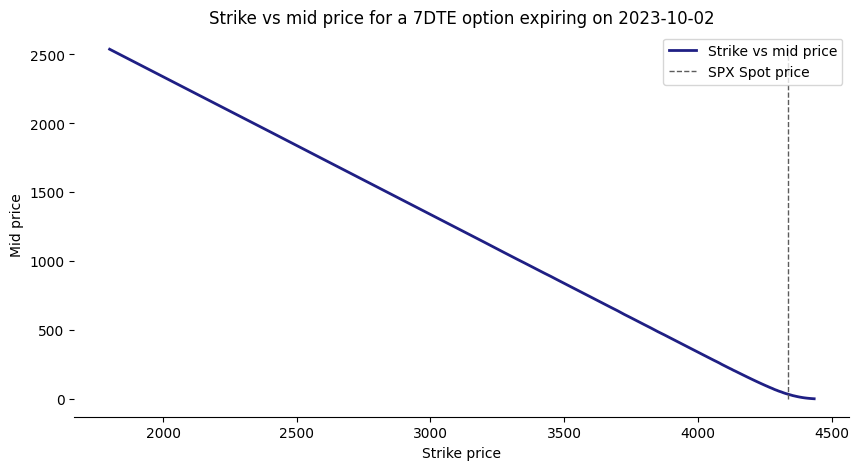

In [56]:
fig, ax = plt.subplots(figsize=(10,5))

# pick a random option chain to display (from the 7dte options)
df = spx_7dte_dfs[random.randint(0,len(spx_7dte_dfs)-1)].copy()
expire_date = pd.to_datetime(df['expire_unix'].mode()[0], unit="s").date()
plt.title(f"Strike vs mid price for a 7DTE option expiring on {expire_date}")

ax.plot(df['strike'], df['call_mid'], color="#1F1F84", linewidth=2, label=f"Strike vs mid price")
ax.vlines(df['underlying_last'].mean(), ymin=0, ymax=df['call_mid'].max(), color="#5C5C5C", linestyle="--", linewidth=1, label="SPX Spot price")

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel("Strike price")
ax.set_ylabel("Mid price");
ax.legend();


Since the scale of this plot is large, it's hard to tell that the curve may not be that smooth.
In order to take the second derivative, we need to interpolate this to a smooth (enough) function.

Doing the smoothing directly on prices is unstable since we need to take the second derivative.


It makes more sense to convert these prices to IV using Black-Scholes, interpolate on IV, and then convert back.

The example below illustrates the problem with trying to smooth prices directly.


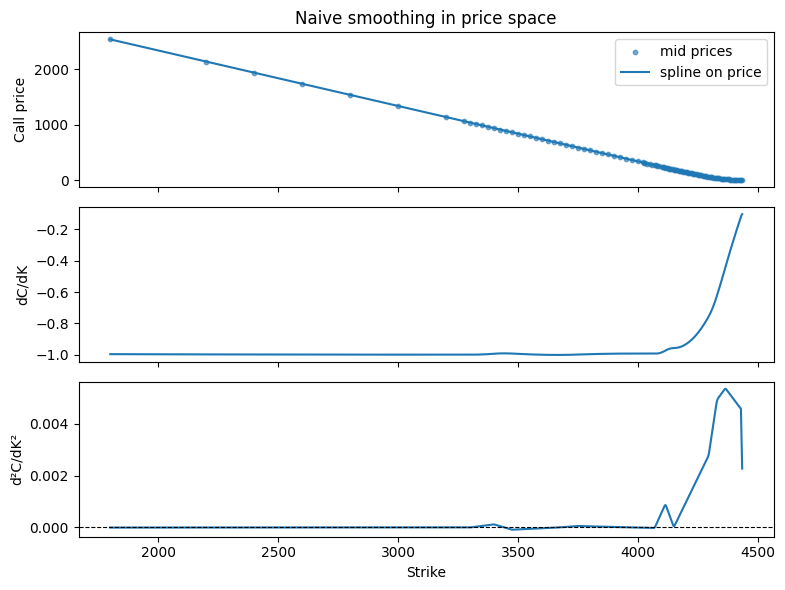

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Assume df already exists with columns 'strikes' and 'call_mid'

# 1. Extract and clean data
K = df["strike"].to_numpy()
C_mid = df["call_mid"].to_numpy()

mask = np.isfinite(K) & np.isfinite(C_mid)
K = K[mask]
C_mid = C_mid[mask]

# sort by strike
order = np.argsort(K)
K = K[order]
C_mid = C_mid[order]

# 2. Naive smoothing in price space: spline on (K, C)
#    s is a smoothing parameter; small but nonzero to avoid exact interpolation
smoothing = 0.05 * len(K)

price_spline = UnivariateSpline(K, C_mid, k=3, s=smoothing)

# 3. Evaluate on a fine strike grid
K_fine = np.linspace(K.min(), K.max(), 1000)
C_smooth = price_spline(K_fine)

# 4. Compute first and second derivatives numerically (naive gradients)
dC_dK = np.gradient(C_smooth, K_fine)
d2C_dK2 = np.gradient(dC_dK, K_fine)

# 5. Plot to illustrate the problem

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# (a) mid prices and smoothed curve
axes[0].scatter(K, C_mid, s=10, alpha=0.6, label="mid prices")
axes[0].plot(K_fine, C_smooth, label="spline on price", linewidth=1.5)
axes[0].set_ylabel("Call price")
axes[0].legend()
axes[0].set_title("Naive smoothing in price space")

# (b) first derivative dC/dK
axes[1].plot(K_fine, dC_dK, linewidth=1.5)
axes[1].set_ylabel("dC/dK")

# (c) second derivative d²C/dK² (this is what you'd treat as pdf)
axes[2].plot(K_fine, d2C_dK2, linewidth=1.5)
axes[2].axhline(0.0, color="black", linestyle="--", linewidth=0.8)
axes[2].set_ylabel("d²C/dK²")
axes[2].set_xlabel("Strike")

plt.tight_layout()
plt.show()


In the following cell, we define functions that convert the price data to implied volatility, perform a smoothed interpolation, convert back to price, and then compute the second derivative.

In [ ]:
def fit_iv_spline(K, iv, F, smoothing_factor=None):
    k_vals = np.log(K / F)
    iv = np.asarray(iv)
    iv = np.maximum(iv, 1e-5)

    log_iv = np.log(iv)

    if smoothing_factor is None:
        n = len(k_vals)
        smoothing_factor = 0.005 * n

    tck = make_splrep(k_vals, log_iv, k=3, s=smoothing_factor)
    

    spline_iv = make_splrep(k_vals, iv, k=3, s=smoothing_factor)
    return spline_iv, k_vals


def fit_iv(strikes, ivs, forward):
    """
    Fit a smooth implied volatility (IV) curve as a function of strike prices.

    This function takes a set of implied volatilities observed at discrete strike prices,
    converts them into log-moneyness space, fits a spline to the IV curve, and then 
    resamples the fitted curve on a fine grid for smoothness. The resampled log-moneyness 
    grid is then converted back to strike prices.

    Parameters
    ----------
    strikes : array-like
        Array of discrete strike prices corresponding to the implied volatilities.
    ivs : array-like
        Array of implied volatilities (in decimals, not percentages) corresponding to `strikes`.
    forward : float
        The current forward price of the underlying asset.

    Returns
    -------
    K_grid : ndarray
        The resampled grid of strike prices.
    iv_smooth_lms : ndarray
        The smoothed implied volatilities corresponding to `K_grid`.
    spline_iv_strike : callable
        The fitted spline function mapping strike to implied volatility.

    Notes
    -----
    - The function assumes that the helper functions `fit_iv_spline` and `resample_curve` 
      are available in the environment.
    - Log-moneyness is defined as `log(K / forward)`.
    """
    spline_iv, log_moneyness_vals = fit_iv_spline(strikes, ivs, forward)
    lm_grid, iv_smooth_lms = resample_curve(spline_iv, log_moneyness_vals, 1000)
    K_grid = forward * np.exp(lm_grid)

    spline_iv_strike = lambda strike: spline_iv(np.log(strike/forward))

    return K_grid, iv_smooth_lms, spline_iv_strike 

def resample_curve(c, x, n):
    """
    Resample the curve c(x) with n points.
    """

    x_grid = np.linspace(x.min(), x.max(), n)
    c_grid = c(x_grid)
    return x_grid, c_grid


def create_pdf_from_df(df: pd.DataFrame, option_type):
    """
    This function creates the pdf as in the create_pdf function below, but the input is just a dataframe that has the format as the dataframes that I construct above.
    The relevant data is extracted and the create_pdf function is called.
    """

    spot_price = df['underlying_last'].mean()   # I am taking the mean just in case, but the underlying_last column should contain only one number
    tte_years = df['tte_years'].mean()          # same deal here

    strikes_fine, bs_prices_fine, f_2 = create_pdf(
        option_type=option_type, # TODO: also do put options
        strikes=df['strike'],
        option_prices=df[f'{option_type}_mid'],
        underlying_prices=df["underlying_last"],
        tte_years=tte_years,
        spot_price=spot_price
    )

    return strikes_fine, bs_prices_fine, f_2



def create_pdf(option_type, strikes, option_prices, underlying_prices, tte_years, spot_price):
    """
    Construct a market-implied probability density function (PDF) for the underlying asset price at option expiration.

    This function uses the set of option-implied volatilities (or prices) across strike prices
    to derive the risk-neutral probability density function (PDF) of the underlying asset's
    terminal price. The resulting distribution reflects the market's collective expectation
    of possible future outcomes under the risk-neutral measure.

    Parameters
    ----------
    option_type : {'call', 'put'}
        The type of the option.
    strikes : array-like
        Array of strike prices corresponding to the observed implied volatilities or option prices.
    implied_volatilities : array-like
        Array of implied volatilities for each strike, typically expressed as annualized decimals.
        These are used to infer option prices (if not provided) and construct the implied distribution.
    underlying_prices : array-like
        Array of option market prices corresponding to the price of the underlying asset at the quote time.
    tte_years : float or array-like
        Time to expiration (T) in years for the options used to infer the PDF.
    spot_price : float
        Current underlying (spot) price of the asset.

    Returns
    -------
    strikes_fine : ndarray
        Array of strikes over which bs_prices_fine is evaluated.
    bs_prices_fine : ndarray
        Array of smoothed option prices.
    f_2 : callable
        A function that takes a price (or array of prices) and returns the estimated probability density.

    Notes
    -----
    - The market-implied PDF is derived from the second derivative of the option price
      with respect to strike (the Breeden–Litzenberger formula).
    - This approach provides a risk-neutral, not a real-world, distribution.
    - Smoothing or interpolation of implied volatilities across strikes is performed
      before numerical differentiation to ensure stability.
    """

    smoothing_df = pd.DataFrame(data={"strike": strikes, "option_prices": option_prices, "underlying_last": underlying_prices}) # tte_years, spot_price)

    # Here we calculate implied volatility using the Black-Scholes formula
    # We'll use 0 for the interest rate; this may not be that accurate, but in our case
    # we don't care that much about extremely accurate implied volatility numbers,
    # because that simply isn't how we're using Black-Scholes. We are just relying on at
    # as an invertible function that can take us to and from IV space, because doing the
    # interpolation and smoothing there is more robust.
    smoothing_df[f'{option_type}_iv'] = smoothing_df.apply(
        lambda row: bs_implied_volatility(
            option_type=option_type,
            market_price=row['option_prices'],
            S0=row['underlying_last'],
            K=row['strike'],
            t=tte_years,
            r=0,
        ),
        axis=1
    )
    
    # often the IV cannot be calculated
    smoothing_df.dropna(inplace=True)

    strikes = smoothing_df['strike']
    ivs = smoothing_df[f'{option_type}_iv']


    # strikes_fine = np.linspace(x.min(), x.max(), 1000)



    # plt.plot(x, y)
    # plt.title("strikes vs iv not smoothed")
    # plt.show()

    # print(x, y, forward)
    strikes_fine, iv_fine, spline_iv_strike = fit_iv(
        strikes=strikes,
        ivs=ivs,
        forward=spot_price
    )

    plt.plot(strikes_fine, iv_fine)
    plt.title("strikes vs iv smoothed (from create_pdf())")
    plt.show()

    # now convert back to prices using Black-Scholes
    smoothing_df['smoothed_price_from_moneyness'] = smoothing_df.apply(
        lambda row: bs_price(
            S0 = spot_price,
            K = row['strike'],
            # sigma = spline_iv(np.log(row['strike'] / F)),
            sigma = spline_iv_strike(row['strike']),
            t=tte_years,
            r=0,
            option_type=option_type
        ),
        axis=1
    )

    plt.plot(smoothing_df['strike'], smoothing_df['smoothed_price_from_moneyness'])
    plt.title('strike vs smoothed price from moneyness')
    plt.show()


    # now take the second derivative of (smoothed) price with respect to strike to generate a pdf
    # note that the smoothed_price row is a function of strike, so we need to resample in order to take a derivative

    # resample
    bs_prices_fine = np.zeros(len(strikes_fine))
    for i in range(len(bs_prices_fine)):
        bs_prices_fine[i] = bs_price(S0 = spot_price,
                        K=strikes_fine[i],
                    sigma=iv_fine[i],
                    t=tte_years,
                    r=0.0,
                    option_type=option_type
        )

    f = np.gradient(bs_prices_fine, strikes_fine)
    f_2 = np.gradient(f, strikes_fine)


    # ensure nonnegative and normalize
    f_2 = np.clip(f_2, 0, None)
    area = np.trapezoid(f_2, strikes_fine)
    # print(f"area of f_2: {area}")
    if area > 0:
        f_2 /= area


    return strikes_fine, bs_prices_fine, CubicSpline(strikes_fine, f_2)



In [ ]:
### I WILL DELETE THIS


from scipy.interpolate import make_splrep

def compute_implied_vols(strikes, prices, spot, T, option_type, r=0.0):
    strikes = np.asarray(strikes)
    prices = np.asarray(prices)

    iv_list = []
    strikes_list = []

    for k, c in zip(strikes, prices):
        try:
            iv = bs_implied_volatility(
                option_type=option_type,
                market_price=c,
                S0=spot,
                K=k,
                t=T,
                r=r,
            )
        except Exception:
            continue

        if iv is None or not np.isfinite(iv):
            continue

        strikes_list.append(k)
        iv_list.append(iv)

    strikes_valid = np.array(strikes_list)
    iv_valid = np.array(iv_list)

    plt.plot(strikes_valid, iv_valid)
    plt.title('strikes_valid vs iv_valid from compute_implied_vols()')
    plt.show()

    order = np.argsort(strikes_valid)
    return strikes_valid[order], iv_valid[order]

def fit_iv_logmoneyness(strikes, iv, forward, smoothing_factor=None):
    """
    Fit a smooth implied vol curve as a function of log-moneyness lm = log(strike/F),
    enforcing positivity by fitting log(iv) and exponentiating.

    Returns iv as a function of log-moneyness and the domain of the fitted curve.
    """
    strikes = np.asarray(strikes)
    iv = np.asarray(iv)

    lm_vals = np.log(strikes/forward)

    iv = np.maximum(iv, 1e-4)
    log_iv = np.log(iv)

    # sort by lm for a well-behaved spline
    order = np.argsort(lm_vals)
    lm_sorted = lm_vals[order]
    log_iv_sorted = log_iv[order]
    strikes_sorted = strikes[order]

    if smoothing_factor is None:
        n = len(lm_vals)
        smoothing_factor = 0.01 * n

    # spline in log-moneyness space
    spline_log_iv = make_splrep(
        lm_sorted,
        log_iv_sorted,
        k=3,
        s=smoothing_factor,
    )

    # --- function of STRIKE, wrapping log-moneyness ---
    def iv_of_strike(K):
        K = np.asarray(K)
        lm = np.log(K / forward)
        log_iv_val = spline_log_iv(lm)      # spline is defined in lm-space
        return np.exp(log_iv_val)     

    # spline_log_iv = make_splrep(lm_vals, log_iv, k=3, s=smoothing_factor)

    # iv_of_lm = lambda lm: np.exp(spline_log_iv(lm))

    K_grid = np.linspace(strikes_sorted.min(), strikes_sorted.max(), 500)
    plt.scatter(strikes_sorted, iv[order], s=10, label="data")
    plt.plot(K_grid, iv_of_strike(K_grid), label="spline IV(K)")
    plt.title("Strike vs IV (smoothed via log-moneyness)")
    plt.legend()
    plt.show()



    # plt.plot(lm_vals, iv_of_lm(lm_vals))
    # plt.title("log moneyness vs iv(lm) smoothed from fit_iv_logmoneyness()")
    # plt.show()

    return iv_of_strike, lm_vals
    

def smooth_option_curve(strikes, option_prices, spot, T, option_type, r=0, forward=None, n_grid=500, smoothing_factor=None):
    strikes = np.asarray(strikes)
    option_prices = np.asarray(option_prices)
 
    plt.plot(strikes, option_prices)
    plt.title("strikes vs option prices from smooth_option_curve")
    plt.show()

    # calculate iv on observed strikes
    strikes_obs, iv_obs = compute_implied_vols(
        strikes=strikes,
        prices=option_prices,
        spot=spot,
        T=T,
        option_type=option_type,
        r=r,
    )

    plt.plot(strikes_obs, iv_obs)
    plt.title("observed strikes vs obs iv")
    plt.show()

    if forward is None:
        forward = spot * np.exp(r * T)

    # fit IV(lm)
    iv_of_lm, lm_vals = fit_iv_logmoneyness(
        strikes=strikes_obs,
        iv=iv_obs,
        forward=forward,
        smoothing_factor=smoothing_factor
    )

    plt.plot(lm_vals, iv_of_lm(lm_vals))
    plt.title("iv(lm) from smooth_option_curve")
    plt.show()

    # make a fine grid in lm and map back to strike
    lm_min, lm_max = lm_vals.min(), lm_vals.max()
    lm_grid = np.linspace(lm_min, lm_max, n_grid)
    strike_grid = forward * np.exp(lm_grid)

    def iv_of_strike(strike):
        strike = np.asarray(strike)
        lm = np.log(strike / forward)
        return iv_of_lm(lm)

    iv_smooth = iv_of_lm(lm_grid)
    iv_smooth = np.maximum(iv_smooth, 1e-5)

    plt.plot(lm_grid, iv_smooth)
    plt.title("lm_grid vs iv_smooth")
    plt.show()

    plt.plot(strike_grid, iv_of_strike(strike_grid))
    plt.title("strike vs iv smoothed from smooth_option_curve()")
    plt.show()

    # convert back to prices via Black–Scholes
    price_smooth = np.array([
        bs_price(
            S0=spot,
            K=strike_grid[i],
            sigma=iv_of_strike(strike_grid)[i],
            t=T,
            r=r,
            option_type=option_type,
        )
        for i in range(len(strike_grid))
    ])
    
    return strike_grid, price_smooth, iv_smooth, iv_of_strike


Found in dataframe 121


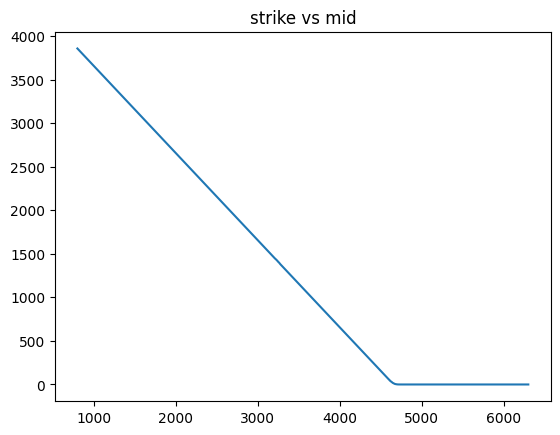

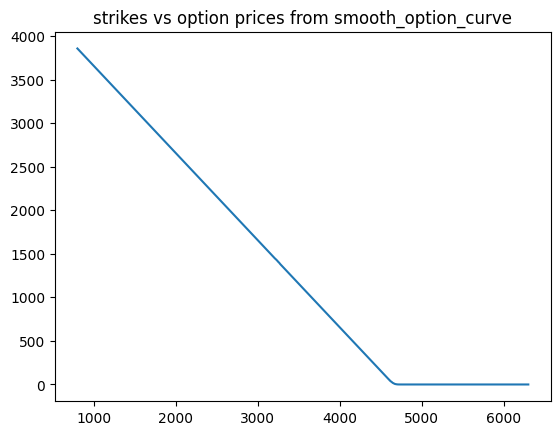

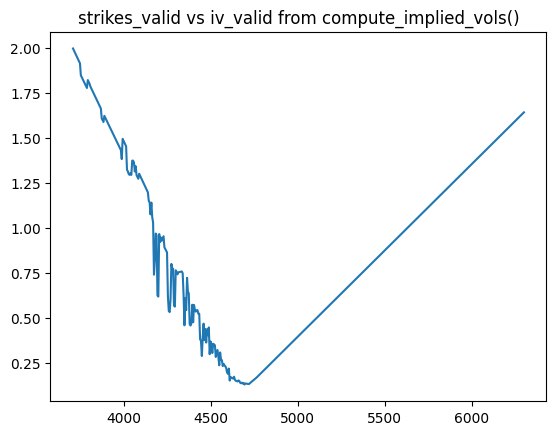

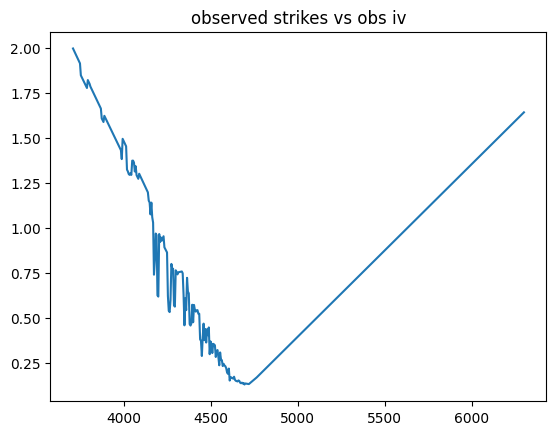

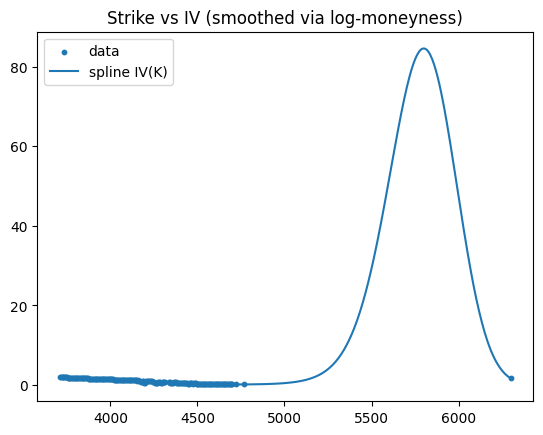

/tmp/ipykernel_1284708/2771097288.py:75: RuntimeWarning: invalid value encountered in log
  lm = np.log(K / forward)
/tmp/ipykernel_1284708/2771097288.py:77: RuntimeWarning: overflow encountered in exp
  return np.exp(log_iv_val)


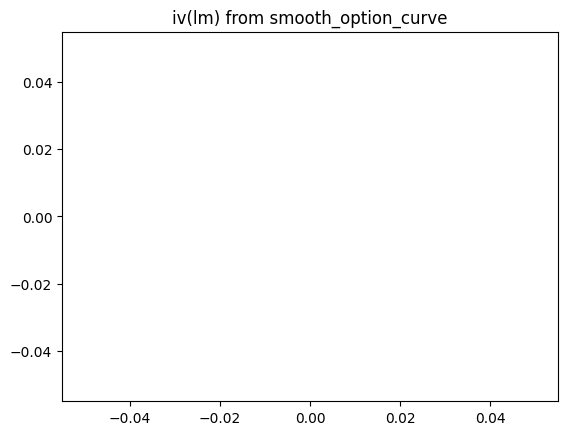

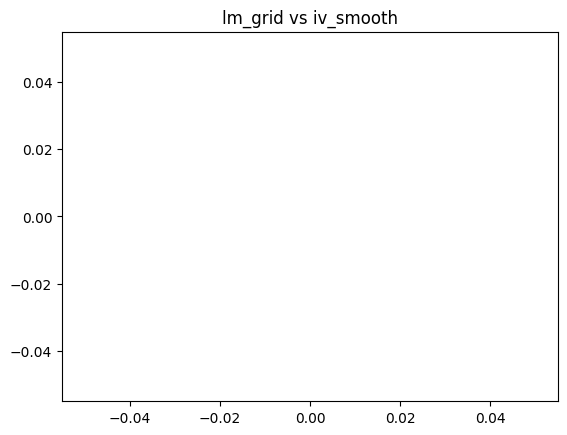

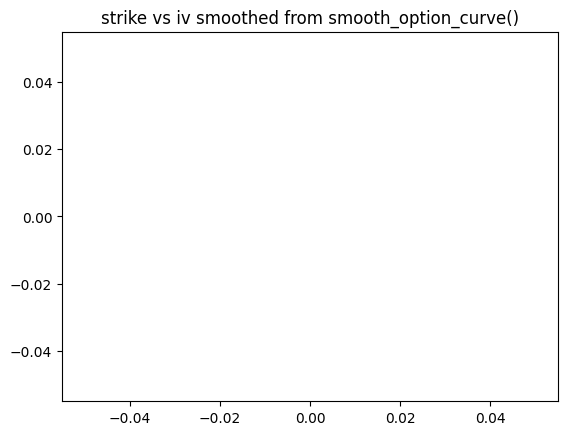

/home/steven/github/implied-stock-distributions/black_scholes.py:40: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))


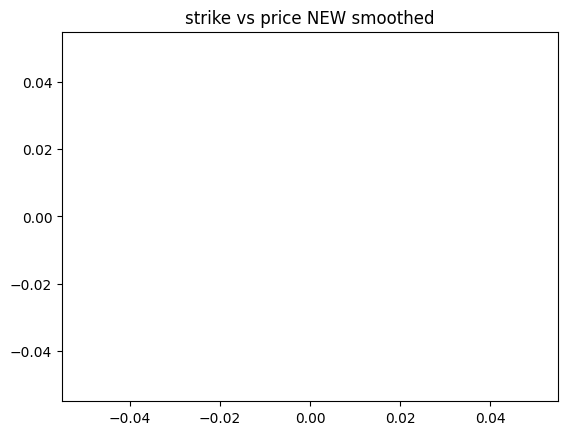

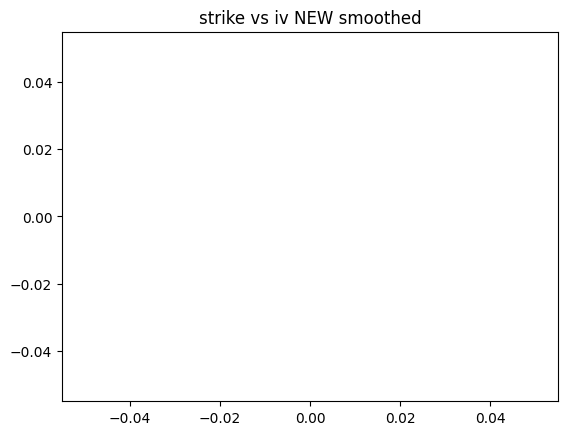

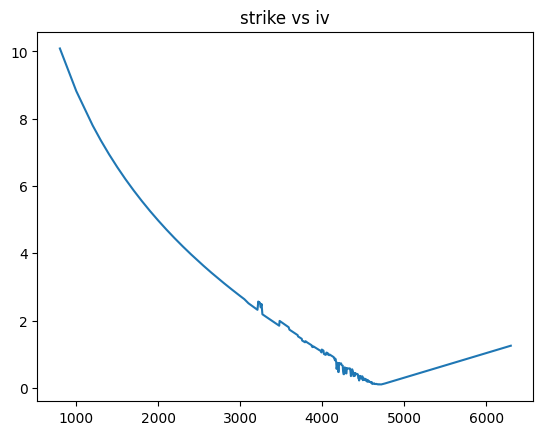

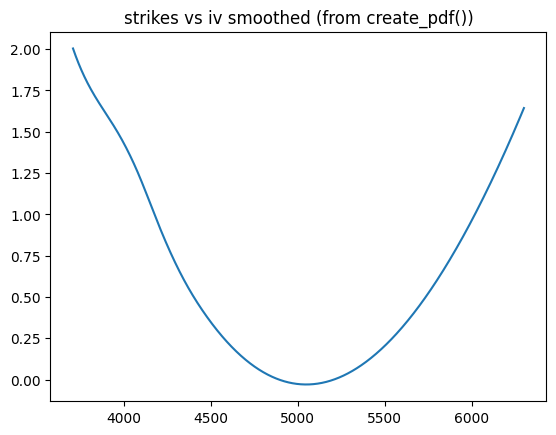

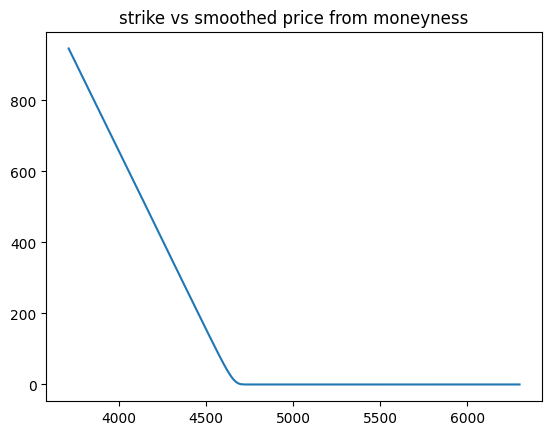

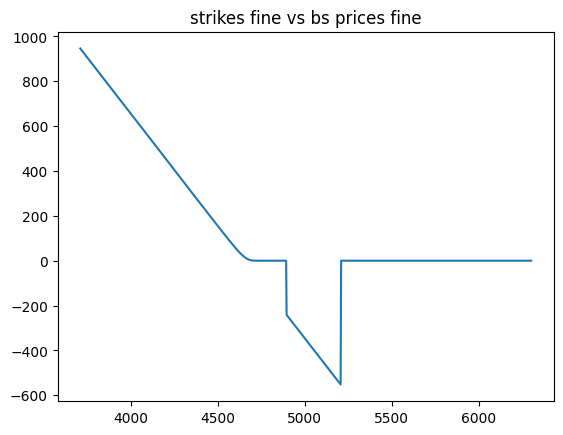

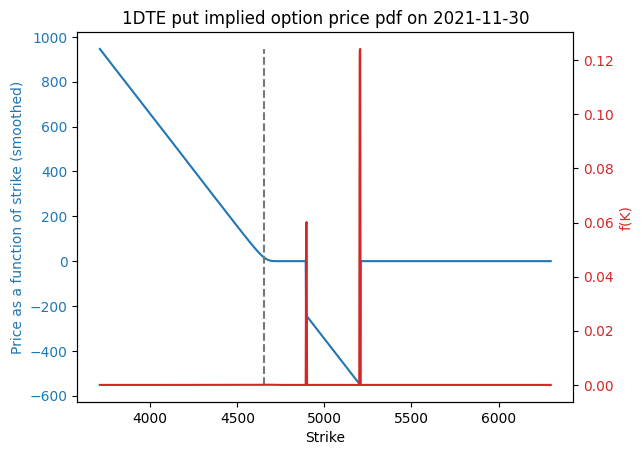

In [142]:


for _ in range(1):
    dfs = {
        "1DTE": spx_1dte_dfs,
        "7DTE": spx_7dte_dfs,
        "28DTE": spx_28dte_dfs,
    }

    df_type = random.choice(["1DTE", "7DTE", "28DTE"])
    # df = dfs[df_type][random.randint(0, len(dfs[df_type]))].copy()

    for i, search_df in enumerate(spx_1dte_dfs):
        if "2021-11-29 16:00:00" in search_df["quote_time"].values:
            print(f"Found in dataframe {i}")
            df = search_df
            break

    # df = spx_1dte_dfs[14]


    # df = spx_28dte_dfs[random.randint(0, len(spx_1dte_dfs))].copy()

    spot_price = df['underlying_last'].mean()   # I am taking the mean just in case, but the underlying_last column should contain only one number

    option_type = ["call", "put"][random.randint(0,1)]

    # strikes_fine, bs_prices_fine, f_2 = create_pdf(
    #     option_type=option_type, # TODO: also do put options
    #     strikes=df['strike'],
    #     option_prices=df[f'{option_type}_mid'],
    #     underlying_prices=df["underlying_last"],
    #     tte_years=tte_years,
    #     spot_price=spot_price
    # )

    plt.plot(df['strike'], df['call_mid'])
    plt.title("strike vs mid")
    plt.show()

    strike_grid, price_smooth, iv_smooth, iv_of_strike = smooth_option_curve(
        strikes=df['strike'],
        option_prices=df['call_mid'],
        spot=spot_price,
        T=df['tte_years'].iloc[0],
        option_type="call",
        r=0,
        forward=None,
        n_grid=500,
    )

    plt.plot(strike_grid, price_smooth)
    plt.title("strike vs price NEW smoothed")
    plt.show()

    plt.plot(strike_grid, iv_of_strike(strike_grid))
    plt.title("strike vs iv NEW smoothed")
    plt.show()

    plt.plot(df['strike'], df['call_iv'])
    plt.title("strike vs iv")
    plt.show()
    
    strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, 'call')

    plt.plot(strikes_fine, bs_prices_fine)
    plt.title("strikes fine vs bs prices fine")
    plt.show()


    fig, ax1 = plt.subplots()

    ax1.plot(strikes_fine, bs_prices_fine)
    ax1.set_xlabel('Strike')
    ax1.set_ylabel('Price as a function of strike (smoothed)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(strikes_fine, f_2(strikes_fine), color='tab:red', label='pdf')
    ax2.set_ylabel('f(K)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # print(f_2(strikes_fine).min())
    ax1.vlines(x=spot_price, ymin=bs_prices_fine.min(), ymax=bs_prices_fine.max(), color="#777777", linestyles="--", label="Spot price")
    # ax1.vlines(x=spot_price * np.exp(0.5 * tte_years), ymin=bs_prices_fine.min(), ymax=bs_prices_fine.max(), color="#777777", linestyles="--", label="Spot price")
    plt.title(f"{df_type} {option_type} implied option price pdf on {pd.to_datetime(df['expire_unix'].iloc[0], unit="s").date()}")
    plt.show()



Now we need to do a little numeric differentiation to apply the Breeden-Litzenberger formula, which we recall from the discussion above says that
$$f(K) = e^{rt} \frac{\partial^2 C}{\partial K^2}$$


## Comparing to market data

The method that we'll use to evaluate the accuracy of the predictions is called the **continuous ranked probability score.**
It is defined by
$$ C(D, y) = \int_{\R} (F_D(x) - \mathbf 1_{x \geq y})^2 \, dx, $$
where
- $F_D$ is the cumulative distribution function of the forecasted distribution $D$,
- $\mathbf 1_{x \geq y}$ is the indicator function, which is 1 if $x \geq y$ and 0 otherwise, and
- $y \in \R$ is the observation.

We will evaluate this integral numerically to assign a score to the predicted pdfs.



We'll start by downloading the SPX data for the same range that we have option data.

In [60]:
earliest_day = pd.to_datetime(spx_df['quote_unix'].min(), unit="s")
latest_day = pd.to_datetime(spx_df['expire_unix'].max(), unit="s")

spx_data = yf.download("^SPX", start=earliest_day, end=latest_day, auto_adjust=True)
display(spx_data)

[*********************100%***********************]  1 of 1 completed

Price,Close,High,Low,Open,Volume
Ticker,^SPX,^SPX,^SPX,^SPX,^SPX
Date,,,,,
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000
2020-01-09,3274.699951,3275.580078,3263.669922,3266.030029,3641230000
...,...,...,...,...,...
2024-01-22,4850.430176,4868.410156,4844.049805,4853.419922,4297610000
2024-01-23,4864.600098,4866.479980,4844.370117,4856.799805,3912800000


Now we implement the CRPS function described above, and a function that will calculate the CRPS given a dataframe of option data.

In [61]:

def crps(D_pdf, y, min_input, max_input, n_samples=500):
    """
    Compute the Continuous Ranked Probability Score (CRPS) for a given predictive
    distribution and observation, when D_pdf is a *pdf* on [min_input, max_input].

    Parameters
    ----------
    D_pdf : callable
        Probability density function f(x) of the predictive distribution.
        It must be (approximately) supported on [min_input, max_input].
    y : float
        Observed value.
    min_input : float
        Lower bound of the domain where the pdf is non-negligible.
    max_input : float
        Upper bound of the domain where the pdf is non-negligible.
    n_samples : int, optional
        Number of grid points used for numerical integration.

    Returns
    -------
    float
        Approximate CRPS(F, y).
    """
    # Create a grid on the domain
    z = np.linspace(min_input, max_input, int(n_samples))
    dz = z[1] - z[0]

    # Evaluate the pdf on the grid and clip in case of numerical errors
    f = np.asarray(D_pdf(z), dtype=float)
    f = np.clip(f, 0.0, np.inf)

    # # Normalize f - actually I think this is always taken care of in other steps
    # norm = np.trapezoid(f, z)
    # if norm <= 0:
    #     raise ValueError("PDF integrates to zero or negative over the given bounds.")
    # f /= norm

    # Build the CDF via cumulative sum
    F = np.cumsum(f) * dz
    # Clip for numerical safety so CDF stays in [0, 1]
    F = np.clip(F, 0.0, 1.0)

    # CRPS integral: \int (F(z) - 1_{z >= y})^2 dz
    indicator = (z >= y).astype(float)
    integrand = (F - indicator) ** 2
    crps_val = np.trapezoid(integrand, z)

    return float(crps_val)


def evaluate_rn_option_prediction_from_df(df: pd.DataFrame, option_type):
    """
    Given a dataframe, construct the risk-neutral implied pdf of option prices at the expiry date of the options in the frame.
    Then look up the actual price of SPX at close on the day of expiration and use CRPS to score the prediction.
    """
    
    expiry_date = str(pd.to_datetime(df['expire_unix'].iloc[0], unit="s").date())
    spx_price_on_expiry_date = spx_data.loc[expiry_date, "Close"].iloc[0]

    strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, option_type)
    
    return crps(f_2, spx_price_on_expiry_date, strikes_fine.min(), strikes_fine.max())

In [62]:

print("Calculating CRPS scores...")
for df_type in [spx_1dte_dfs, spx_7dte_dfs, spx_28dte_dfs]:
    c = 0
    p = 0
    for df in df_type:
        
        call_score = evaluate_rn_option_prediction_from_df(df, 'call')
        put_score = evaluate_rn_option_prediction_from_df(df, 'put')
        c += call_score
        p += put_score

    print(f"Average CRPS for {int(df_type[0]['dte'].iloc[0])} DTE calls: {c / len( df_type ) :.2f}")
    print(f"Average CRPS for {int(df_type[0]['dte'].iloc[0])} DTE puts: {p / len( df_type ) :.2f}")


Calculating CRPS scores...
Average CRPS for 1 DTE calls if all predictions were correct: 33.90
Average CRPS for 1 DTE puts if all predictions were correct: 32.03
Average CRPS for 7 DTE calls if all predictions were correct: 54.42
Average CRPS for 7 DTE puts if all predictions were correct: 55.52
Average CRPS for 28 DTE calls if all predictions were correct: 93.88
Average CRPS for 28 DTE puts if all predictions were correct: 94.62


By themselves these numbers are fairly abstract; does a score of 

Calculating CRPS scores in the hypothetical case that all predictions turn out to be correct...
Maybe some bad data in 1.0 DTE calls quoted on 13938    2020-04-21 16:00:00
13939    2020-04-21 16:00:00
13940    2020-04-21 16:00:00
13941    2020-04-21 16:00:00
13942    2020-04-21 16:00:00
                ...         
14119    2020-04-21 16:00:00
14120    2020-04-21 16:00:00
14130    2020-04-21 16:00:00
14142    2020-04-21 16:00:00
14152    2020-04-21 16:00:00
Name: quote_time, Length: 164, dtype: object


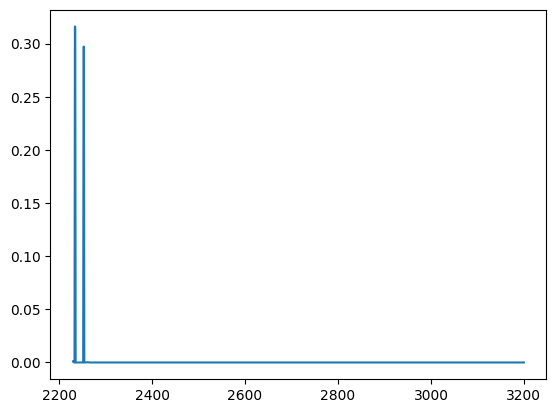

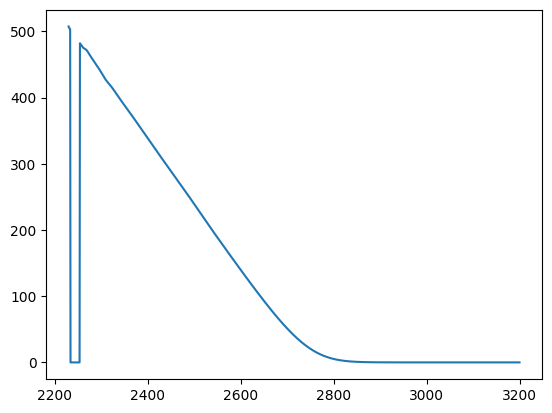

Maybe some bad data in 1.0 DTE calls quoted on 16682    2020-04-30 16:00:00
16683    2020-04-30 16:00:00
16684    2020-04-30 16:00:00
16685    2020-04-30 16:00:00
16686    2020-04-30 16:00:00
                ...         
16938    2020-04-30 16:00:00
16939    2020-04-30 16:00:00
16940    2020-04-30 16:00:00
16942    2020-04-30 16:00:00
16943    2020-04-30 16:00:00
Name: quote_time, Length: 220, dtype: object


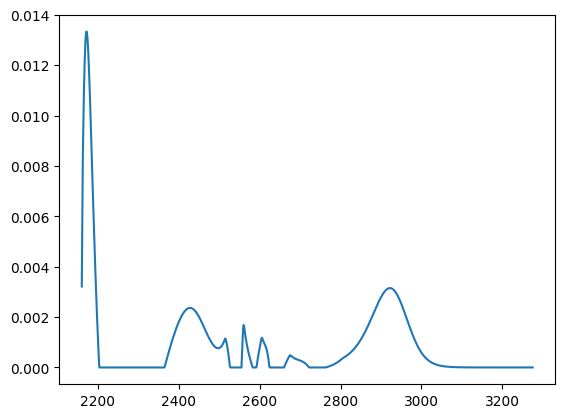

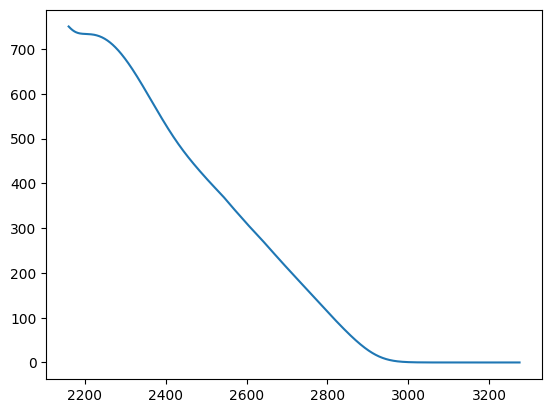

Maybe some bad data in 1.0 DTE calls quoted on 43426    2020-12-23 16:00:00
43427    2020-12-23 16:00:00
43428    2020-12-23 16:00:00
43429    2020-12-23 16:00:00
43430    2020-12-23 16:00:00
                ...         
43607    2020-12-23 16:00:00
43608    2020-12-23 16:00:00
43609    2020-12-23 16:00:00
43610    2020-12-23 16:00:00
43611    2020-12-23 16:00:00
Name: quote_time, Length: 186, dtype: object


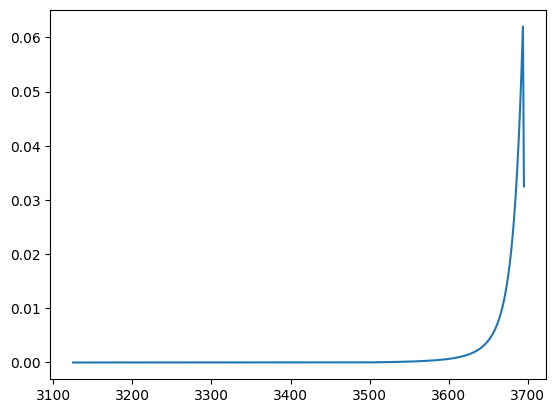

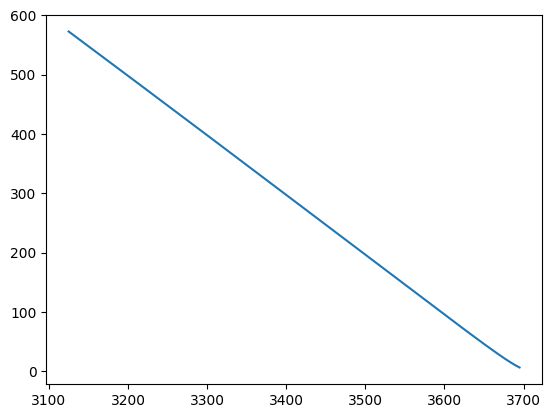

Maybe some bad data in 1.0 DTE calls quoted on 48935    2020-08-20 16:00:00
48936    2020-08-20 16:00:00
48937    2020-08-20 16:00:00
48938    2020-08-20 16:00:00
48939    2020-08-20 16:00:00
                ...         
49221    2020-08-20 16:00:00
49222    2020-08-20 16:00:00
49223    2020-08-20 16:00:00
49224    2020-08-20 16:00:00
49228    2020-08-20 16:00:00
Name: quote_time, Length: 291, dtype: object


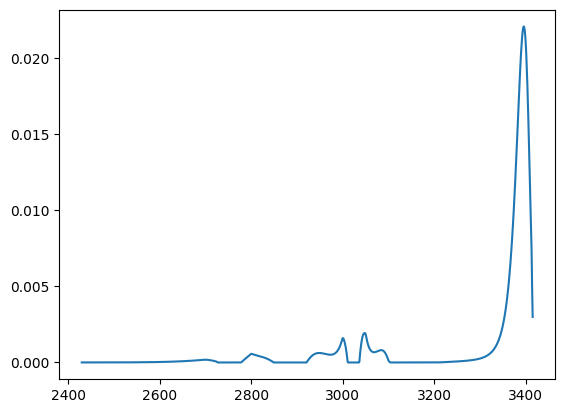

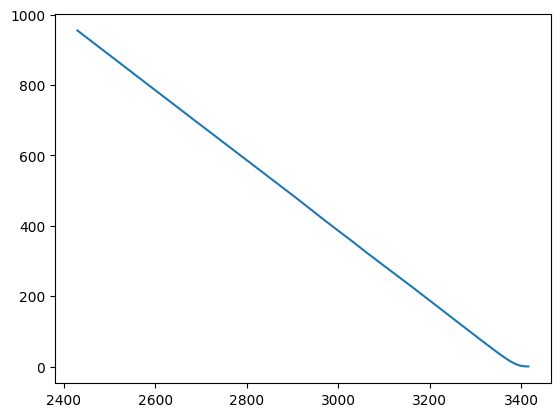

Maybe some bad data in 1.0 DTE calls quoted on 79739    2020-11-19 16:00:00
79740    2020-11-19 16:00:00
79741    2020-11-19 16:00:00
79742    2020-11-19 16:00:00
79743    2020-11-19 16:00:00
                ...         
80022    2020-11-19 16:00:00
80023    2020-11-19 16:00:00
80024    2020-11-19 16:00:00
80026    2020-11-19 16:00:00
80027    2020-11-19 16:00:00
Name: quote_time, Length: 262, dtype: object


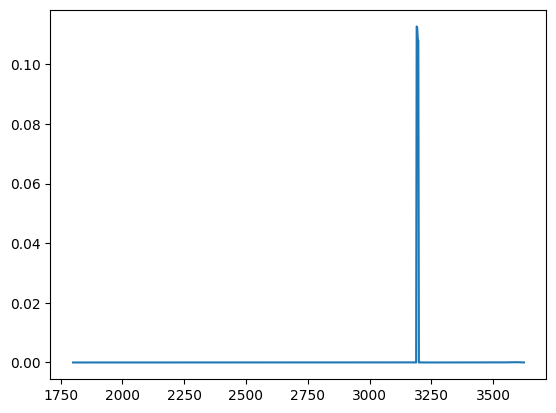

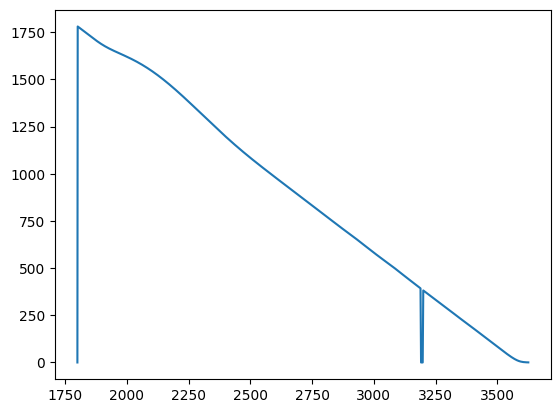

Maybe some bad data in 1.0 DTE calls quoted on 96016    2021-11-29 16:00:00
96017    2021-11-29 16:00:00
96018    2021-11-29 16:00:00
96019    2021-11-29 16:00:00
96020    2021-11-29 16:00:00
                ...         
96315    2021-11-29 16:00:00
96316    2021-11-29 16:00:00
96320    2021-11-29 16:00:00
96329    2021-11-29 16:00:00
96405    2021-11-29 16:00:00
Name: quote_time, Length: 300, dtype: object


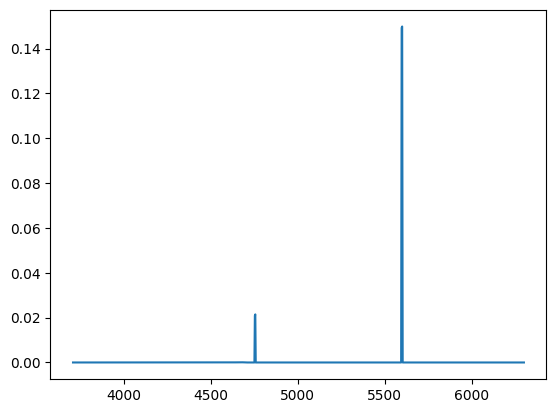

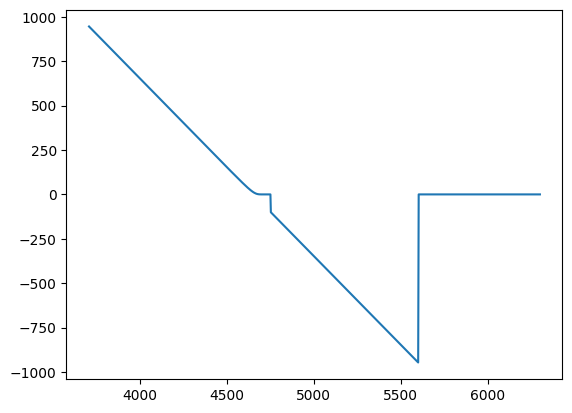

Maybe some bad data in 1.0 DTE calls quoted on 107447    2021-12-16 16:00:00
107448    2021-12-16 16:00:00
107449    2021-12-16 16:00:00
107450    2021-12-16 16:00:00
107451    2021-12-16 16:00:00
                 ...         
107783    2021-12-16 16:00:00
107788    2021-12-16 16:00:00
107790    2021-12-16 16:00:00
107802    2021-12-16 16:00:00
107806    2021-12-16 16:00:00
Name: quote_time, Length: 338, dtype: object


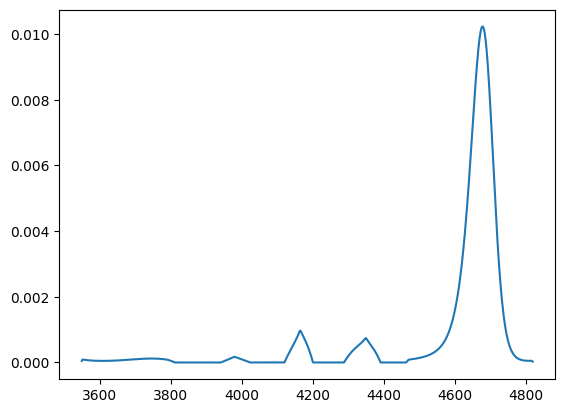

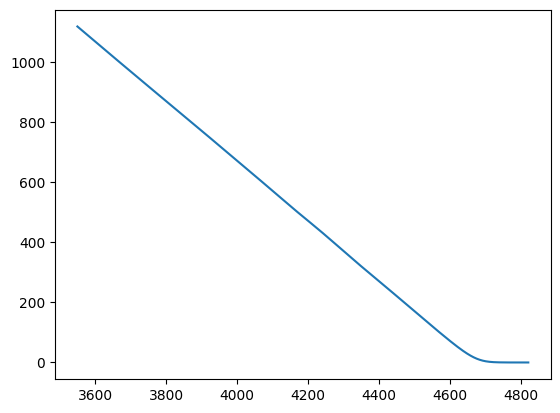

Maybe some bad data in 1.0 DTE calls quoted on 109314    2021-12-22 16:00:00
109317    2021-12-22 16:00:00
109319    2021-12-22 16:00:00
109320    2021-12-22 16:00:00
109321    2021-12-22 16:00:00
                 ...         
109536    2021-12-22 16:00:00
109537    2021-12-22 16:00:00
109538    2021-12-22 16:00:00
109539    2021-12-22 16:00:00
109540    2021-12-22 16:00:00
Name: quote_time, Length: 73, dtype: object


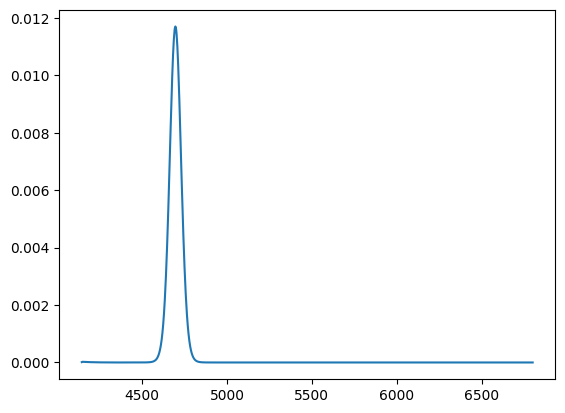

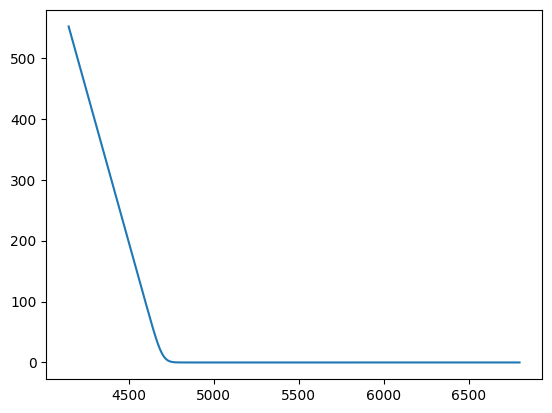

Maybe some bad data in 1.0 DTE calls quoted on 124277    2021-01-21 16:00:00
124278    2021-01-21 16:00:00
124279    2021-01-21 16:00:00
124280    2021-01-21 16:00:00
124281    2021-01-21 16:00:00
                 ...         
124487    2021-01-21 16:00:00
124488    2021-01-21 16:00:00
124489    2021-01-21 16:00:00
124490    2021-01-21 16:00:00
124492    2021-01-21 16:00:00
Name: quote_time, Length: 213, dtype: object


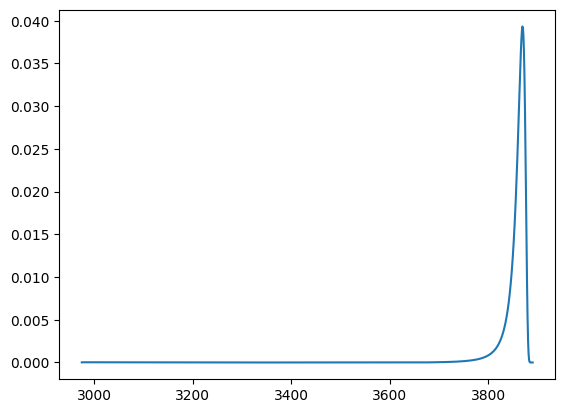

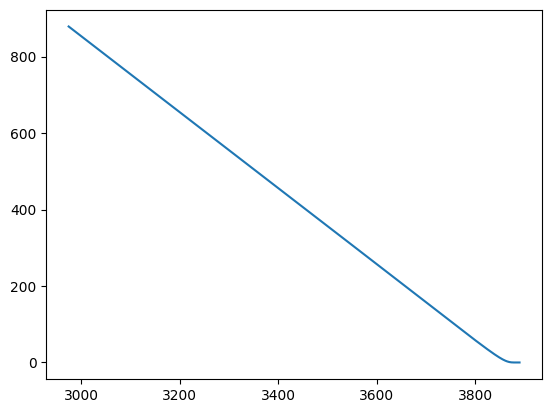

Maybe some bad data in 1.0 DTE calls quoted on 140222    2021-04-27 16:00:00
140223    2021-04-27 16:00:00
140224    2021-04-27 16:00:00
140225    2021-04-27 16:00:00
140226    2021-04-27 16:00:00
                 ...         
140395    2021-04-27 16:00:00
140399    2021-04-27 16:00:00
140416    2021-04-27 16:00:00
140423    2021-04-27 16:00:00
140427    2021-04-27 16:00:00
Name: quote_time, Length: 145, dtype: object


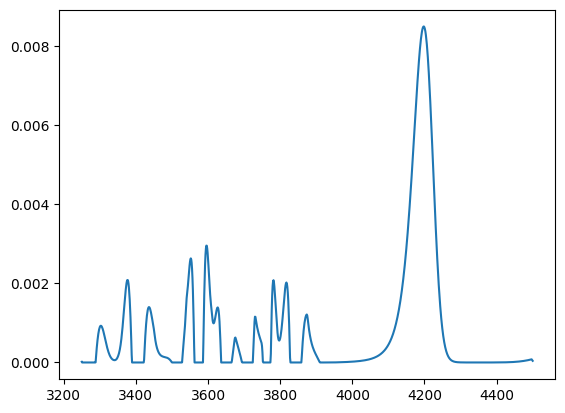

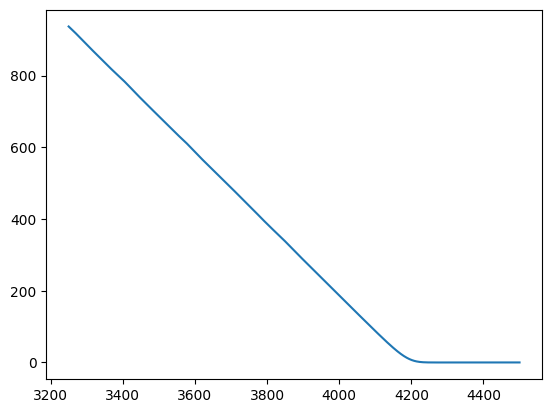

Maybe some bad data in 1.0 DTE calls quoted on 152149    2021-09-14 16:00:00
152150    2021-09-14 16:00:00
152151    2021-09-14 16:00:00
152153    2021-09-14 16:00:00
152154    2021-09-14 16:00:00
                 ...         
152305    2021-09-14 16:00:00
152387    2021-09-14 16:00:00
152389    2021-09-14 16:00:00
152390    2021-09-14 16:00:00
152391    2021-09-14 16:00:00
Name: quote_time, Length: 159, dtype: object


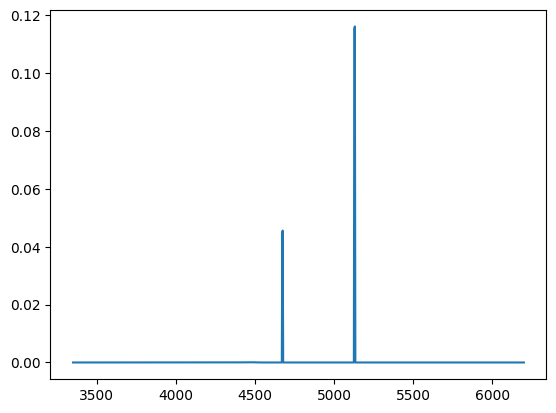

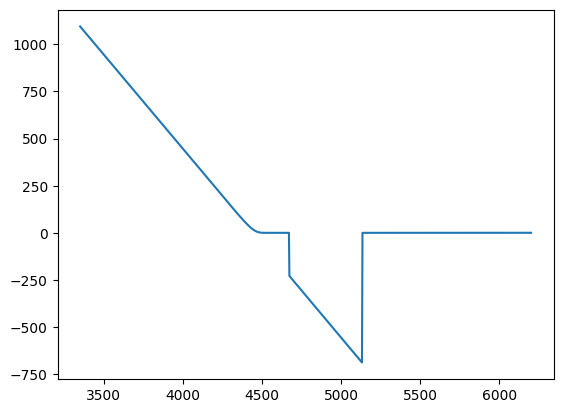

Maybe some bad data in 1.0 DTE calls quoted on 161178    2021-07-15 16:00:00
161179    2021-07-15 16:00:00
161180    2021-07-15 16:00:00
161181    2021-07-15 16:00:00
161206    2021-07-15 16:00:00
                 ...         
161323    2021-07-15 16:00:00
161324    2021-07-15 16:00:00
161325    2021-07-15 16:00:00
161326    2021-07-15 16:00:00
161327    2021-07-15 16:00:00
Name: quote_time, Length: 108, dtype: object


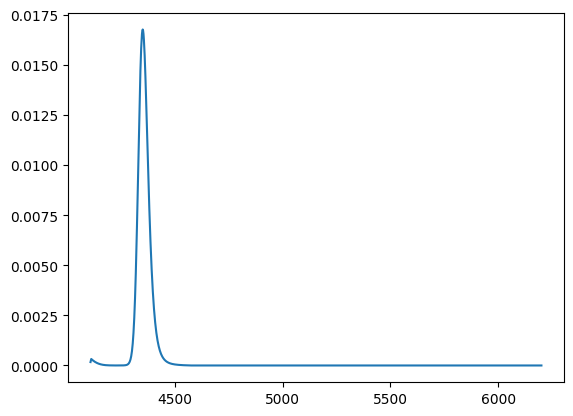

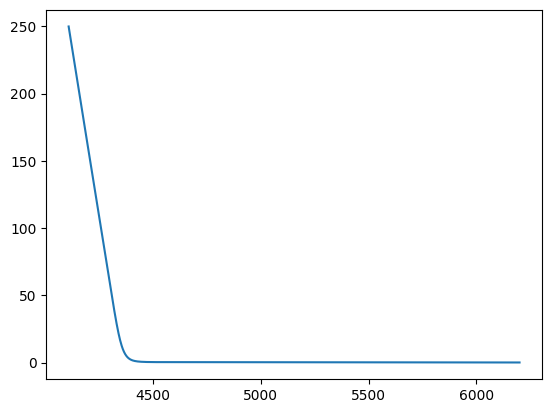

Maybe some bad data in 1.0 DTE calls quoted on 164261    2021-07-27 16:00:00
164269    2021-07-27 16:00:00
164270    2021-07-27 16:00:00
164271    2021-07-27 16:00:00
164272    2021-07-27 16:00:00
                 ...         
164442    2021-07-27 16:00:00
164477    2021-07-27 16:00:00
164478    2021-07-27 16:00:00
164479    2021-07-27 16:00:00
164480    2021-07-27 16:00:00
Name: quote_time, Length: 154, dtype: object


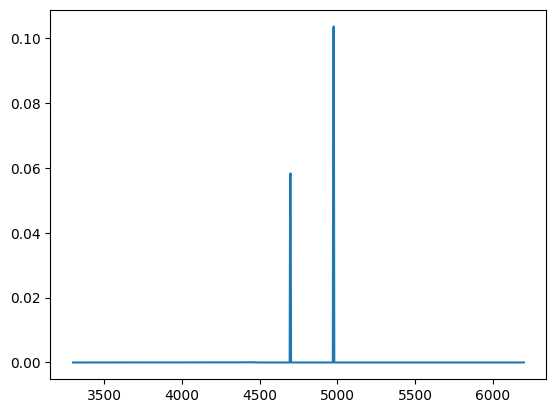

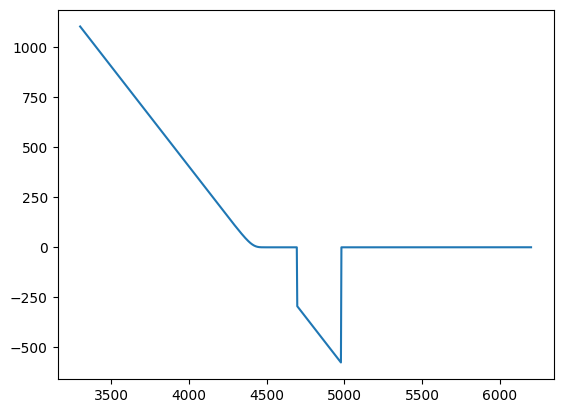

Maybe some bad data in 1.0 DTE calls quoted on 168715    2021-08-12 16:00:00
168726    2021-08-12 16:00:00
168727    2021-08-12 16:00:00
168732    2021-08-12 16:00:00
168734    2021-08-12 16:00:00
                 ...         
168941    2021-08-12 16:00:00
168942    2021-08-12 16:00:00
169014    2021-08-12 16:00:00
169015    2021-08-12 16:00:00
169016    2021-08-12 16:00:00
Name: quote_time, Length: 191, dtype: object


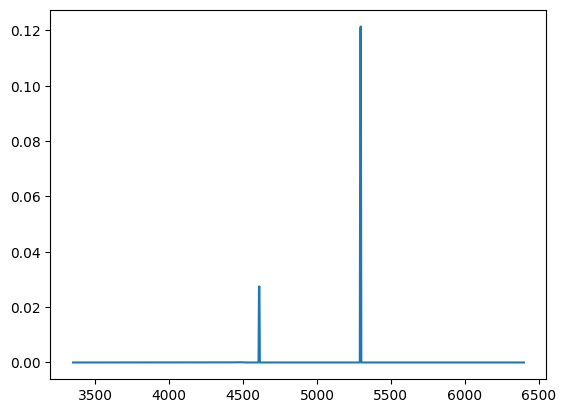

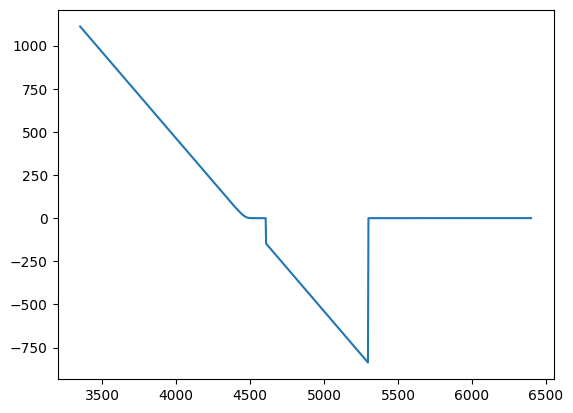

Maybe some bad data in 1.0 DTE calls quoted on 175358    2022-10-04 16:00:00
175359    2022-10-04 16:00:00
175360    2022-10-04 16:00:00
175361    2022-10-04 16:00:00
175362    2022-10-04 16:00:00
                 ...         
175523    2022-10-04 16:00:00
175524    2022-10-04 16:00:00
175525    2022-10-04 16:00:00
175526    2022-10-04 16:00:00
175527    2022-10-04 16:00:00
Name: quote_time, Length: 148, dtype: object


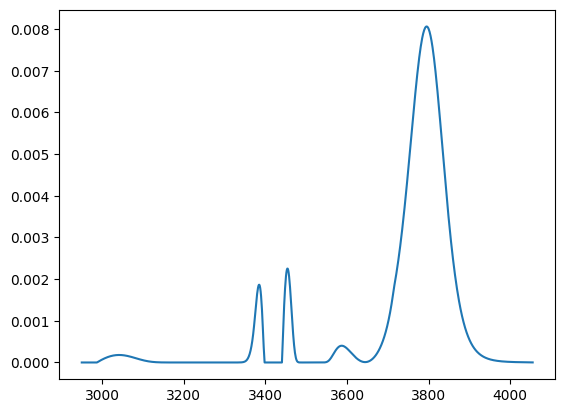

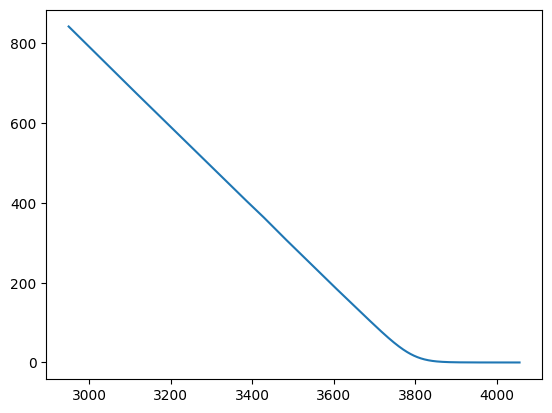

Maybe some bad data in 1.0 DTE calls quoted on 197002    2022-08-22 16:00:00
197003    2022-08-22 16:00:00
197004    2022-08-22 16:00:00
197005    2022-08-22 16:00:00
197006    2022-08-22 16:00:00
                 ...         
197080    2022-08-22 16:00:00
197081    2022-08-22 16:00:00
197082    2022-08-22 16:00:00
197083    2022-08-22 16:00:00
197139    2022-08-22 16:00:00
Name: quote_time, Length: 83, dtype: object


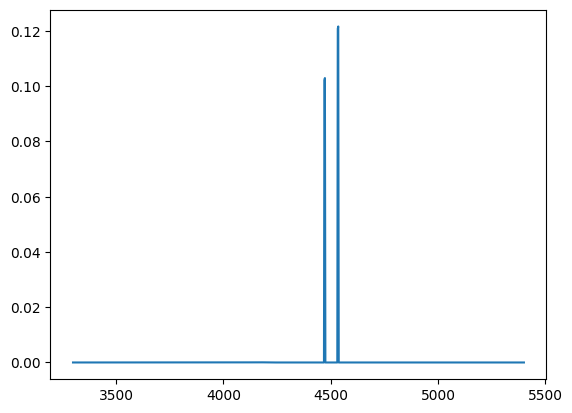

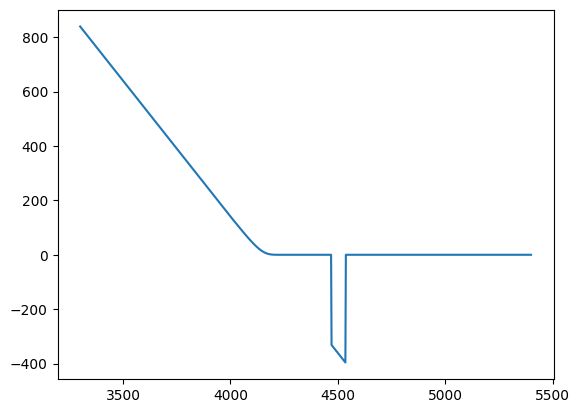

Maybe some bad data in 1.0 DTE calls quoted on 199055    2022-08-29 16:00:00
199056    2022-08-29 16:00:00
199057    2022-08-29 16:00:00
199058    2022-08-29 16:00:00
199059    2022-08-29 16:00:00
                 ...         
199136    2022-08-29 16:00:00
199137    2022-08-29 16:00:00
199138    2022-08-29 16:00:00
199139    2022-08-29 16:00:00
199215    2022-08-29 16:00:00
Name: quote_time, Length: 86, dtype: object


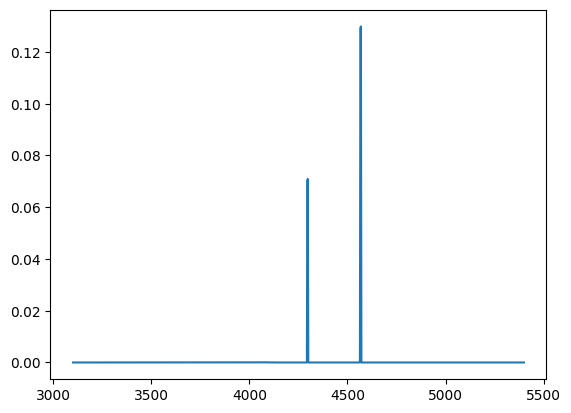

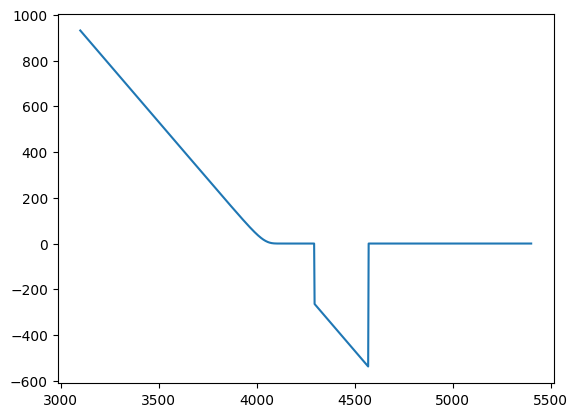

Maybe some bad data in 1.0 DTE calls quoted on 280759    2023-11-28 16:00:00
280760    2023-11-28 16:00:00
280761    2023-11-28 16:00:00
280762    2023-11-28 16:00:00
280763    2023-11-28 16:00:00
                 ...         
280899    2023-11-28 16:00:00
280900    2023-11-28 16:00:00
280901    2023-11-28 16:00:00
280902    2023-11-28 16:00:00
280903    2023-11-28 16:00:00
Name: quote_time, Length: 145, dtype: object


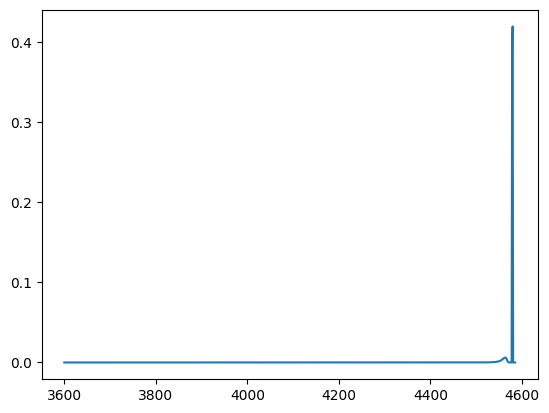

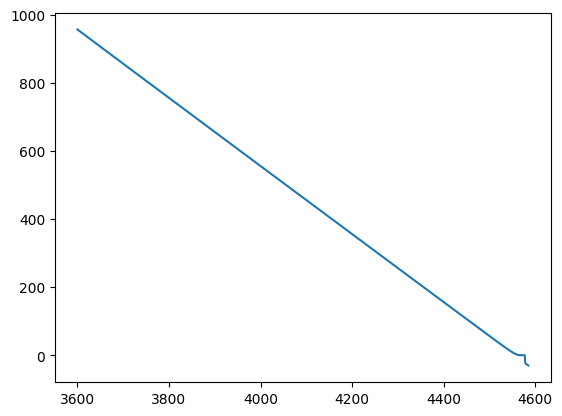

Maybe some bad data in 1.0 DTE calls quoted on 294110    2023-12-07 16:00:00
294111    2023-12-07 16:00:00
294112    2023-12-07 16:00:00
294113    2023-12-07 16:00:00
294114    2023-12-07 16:00:00
                 ...         
294265    2023-12-07 16:00:00
294266    2023-12-07 16:00:00
294267    2023-12-07 16:00:00
294268    2023-12-07 16:00:00
294284    2023-12-07 16:00:00
Name: quote_time, Length: 159, dtype: object


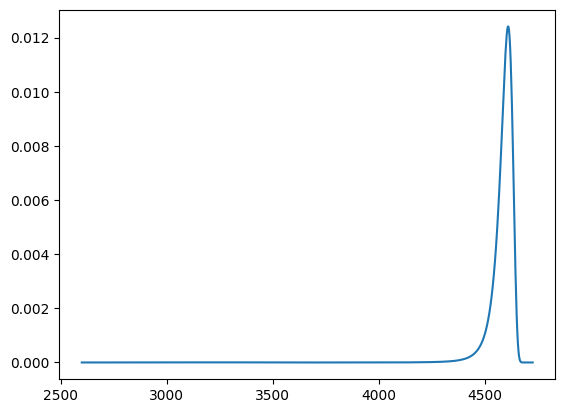

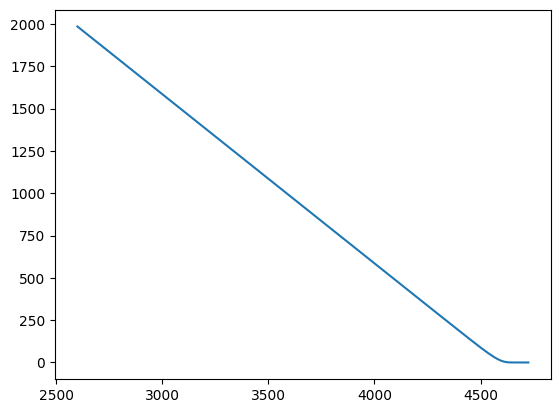

Maybe some bad data in 1.0 DTE calls quoted on 300115    2023-12-27 16:00:00
300116    2023-12-27 16:00:00
300117    2023-12-27 16:00:00
300118    2023-12-27 16:00:00
300119    2023-12-27 16:00:00
                 ...         
300234    2023-12-27 16:00:00
300235    2023-12-27 16:00:00
300236    2023-12-27 16:00:00
300237    2023-12-27 16:00:00
300238    2023-12-27 16:00:00
Name: quote_time, Length: 124, dtype: object


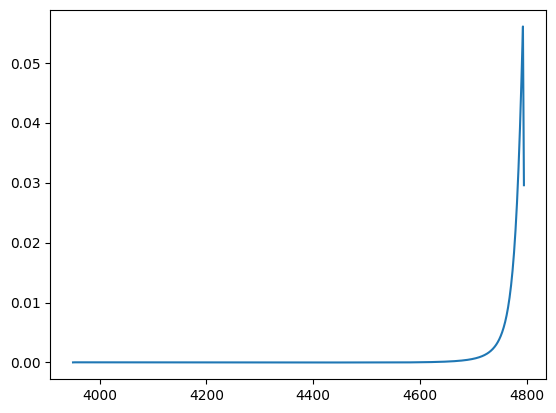

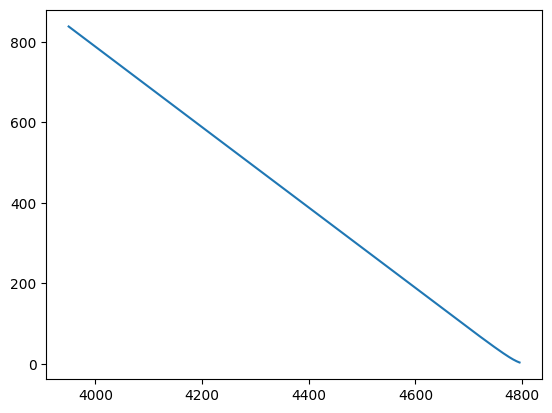

Maybe some bad data in 1.0 DTE calls quoted on 304915    2023-10-12 16:00:00
304916    2023-10-12 16:00:00
304917    2023-10-12 16:00:00
304918    2023-10-12 16:00:00
304919    2023-10-12 16:00:00
                 ...         
305051    2023-10-12 16:00:00
305052    2023-10-12 16:00:00
305053    2023-10-12 16:00:00
305054    2023-10-12 16:00:00
305055    2023-10-12 16:00:00
Name: quote_time, Length: 136, dtype: object


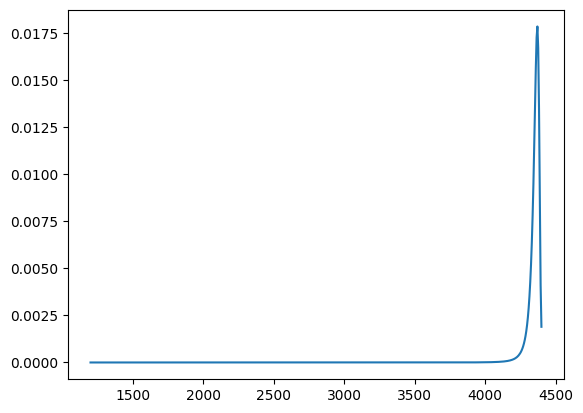

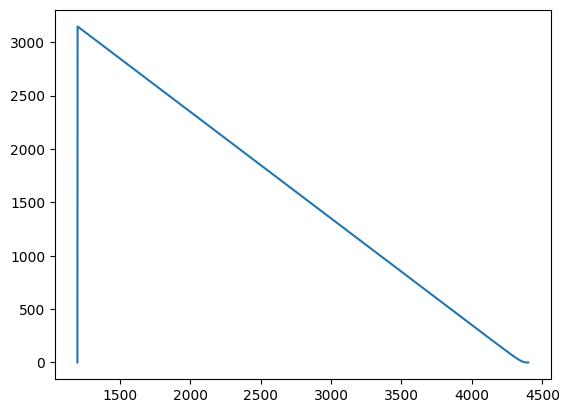

Maybe some bad data in 1.0 DTE calls quoted on 309280    2023-10-31 16:00:00
309281    2023-10-31 16:00:00
309282    2023-10-31 16:00:00
309283    2023-10-31 16:00:00
309284    2023-10-31 16:00:00
                 ...         
309385    2023-10-31 16:00:00
309386    2023-10-31 16:00:00
309395    2023-10-31 16:00:00
309441    2023-10-31 16:00:00
309442    2023-10-31 16:00:00
Name: quote_time, Length: 110, dtype: object


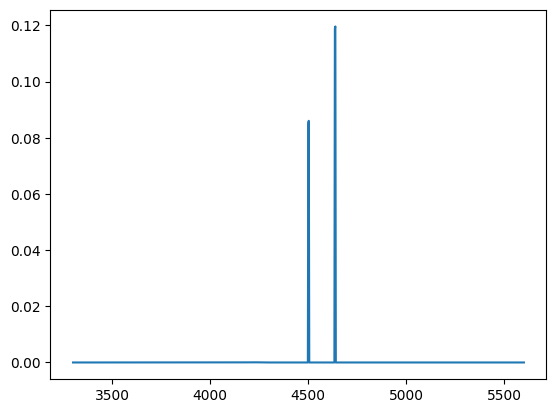

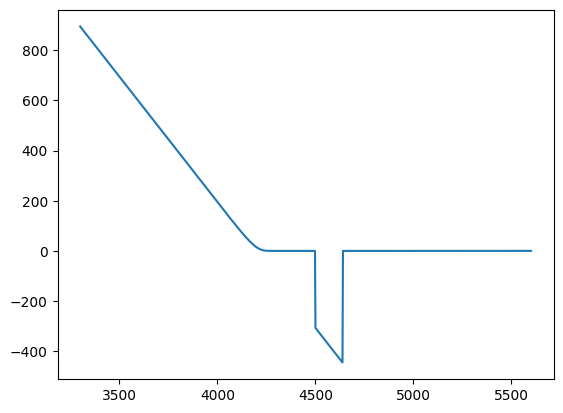

Maybe some bad data in 1.0 DTE calls quoted on 323994    2023-06-26 16:00:00
323995    2023-06-26 16:00:00
323996    2023-06-26 16:00:00
323997    2023-06-26 16:00:00
323998    2023-06-26 16:00:00
                 ...         
324089    2023-06-26 16:00:00
324090    2023-06-26 16:00:00
324091    2023-06-26 16:00:00
324092    2023-06-26 16:00:00
324145    2023-06-26 16:00:00
Name: quote_time, Length: 99, dtype: object


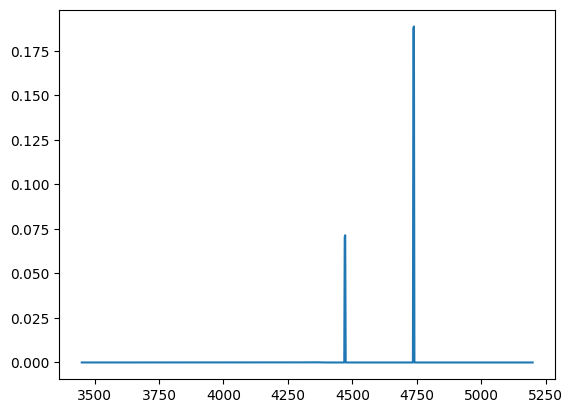

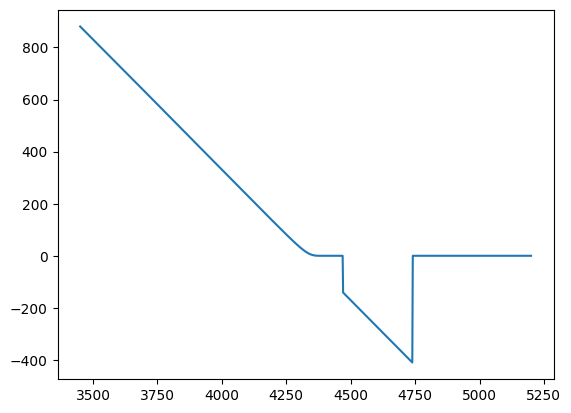

Maybe some bad data in 1.0 DTE calls quoted on 329323    2023-09-14 16:00:00
329324    2023-09-14 16:00:00
329325    2023-09-14 16:00:00
329326    2023-09-14 16:00:00
329329    2023-09-14 16:00:00
                 ...         
329566    2023-09-14 16:00:00
329567    2023-09-14 16:00:00
329568    2023-09-14 16:00:00
329569    2023-09-14 16:00:00
329570    2023-09-14 16:00:00
Name: quote_time, Length: 213, dtype: object


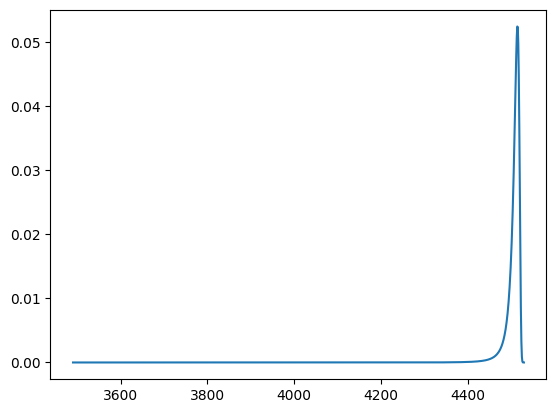

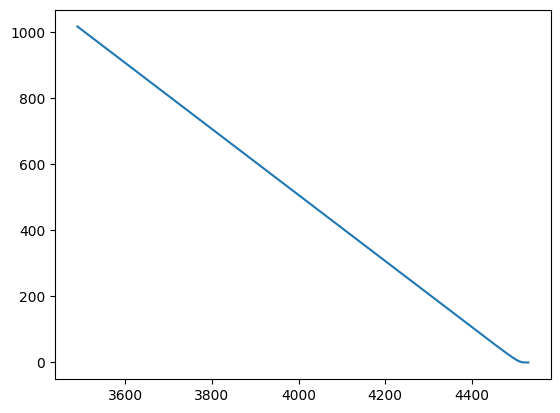

Maybe some bad data in 1.0 DTE calls quoted on 342060    2023-07-26 16:00:00
342061    2023-07-26 16:00:00
342062    2023-07-26 16:00:00
342063    2023-07-26 16:00:00
342064    2023-07-26 16:00:00
                 ...         
342165    2023-07-26 16:00:00
342166    2023-07-26 16:00:00
342167    2023-07-26 16:00:00
342201    2023-07-26 16:00:00
342205    2023-07-26 16:00:00
Name: quote_time, Length: 88, dtype: object


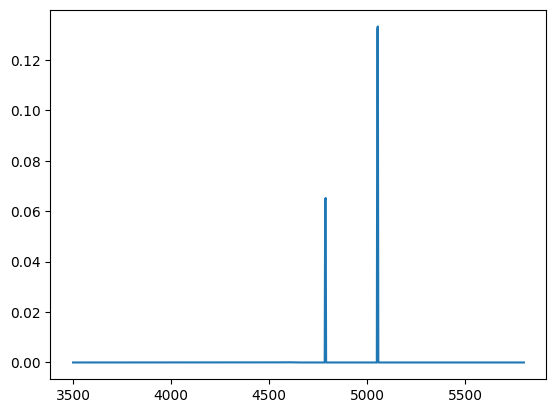

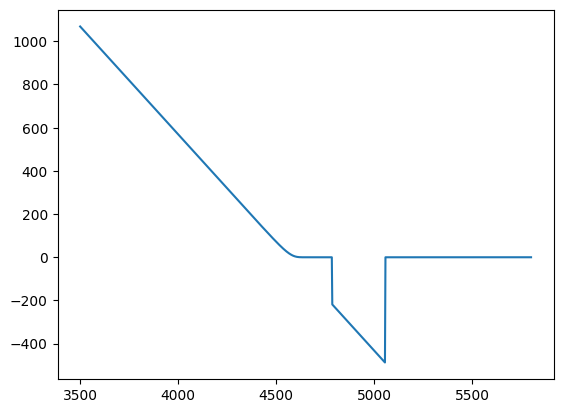

KeyboardInterrupt: 

In [63]:
from scipy.optimize import minimize_scalar

print("Calculating CRPS scores in the hypothetical case that all predictions turn out to be correct...")
for df_type in [spx_1dte_dfs, spx_7dte_dfs, spx_28dte_dfs]:
    s = 0
    for df in df_type:
        expiry_date = str(pd.to_datetime(df['expire_unix'].iloc[0], unit="s").date())

        strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, 'call')
        max_probability_price = minimize_scalar( lambda x: -f_2(x), bounds=(strikes_fine.min(), strikes_fine.max()), method='bounded').x
        
        score = crps(f_2, max_probability_price, strikes_fine.min(), strikes_fine.max())
        if score > 150:
            print(f"Maybe some bad data in {df['dte'].iloc[0]} DTE calls quoted on {df['quote_time']}")
            plt.plot(strikes_fine, f_2(strikes_fine))
            plt.show()
            plt.plot(strikes_fine, bs_prices_fine)
            plt.show()
        s += score                             

    print(f"Average CRPS for {int(df_type[0]['dte'].iloc[0])} DTE calls if all predictions were correct: {s / len( df_type ) :.2f}")

## Converting the risk-neutral density to a real-world density

As discussed before, the density that we are extracting from the option prices is not just purely the market's prediction of where the stock is likely to move.
So far I have obtained a density $f_Q$ for the risk-neutral probability measure $Q$, and I would like to convert this to a density $f_P$ for the real-world probability measure $P$.
In general there is not an obvious way to do this.

Recall our previous calculation that

\begin{align*}
C(K, T) &= e^{-rT} \mathbb E_Q(\max\{S_T - K, 0\}) \\
&= e^{-rT} \int_0^\infty \max\{x - K, 0\} f_Q(x) \, d x
\end{align*}
We can continue this:
\begin{align*}
\qquad \qquad \qquad \quad &= e^{-rT} \int_0^\infty \max\{x - K, 0\} \frac{f_Q(x)}{f_P(x)} f_P(x) \, dx \\
&= \mathbb E_P[ \max\{S_T - K, 0\} \cdot m(S_T) ],
\end{align*}
where $m(S_T)$ is a random variable called the *stochastic discount factor*, and is defined by the equation above, so that
$$
m(S_T) = e^{-r T} \frac{f_Q(S_T)}{f_P(S_T)}
$$


In [ ]:


def physical_density_from_rn(fQ, s_min, s_max, n_grid=500, gamma=4):
    """
    Convert a callable risk-neutral pdf fQ(s) into a callable physical pdf fP(s)
    under a CRRA/power-utility assumption with coefficient gamma.

    Parameters
    ----------
    fQ : callable
        Function fQ(s): risk-neutral pdf (should integrate ≈ 1 over its support).
    s_min, s_max : float
        Bounds of the support (integration domain).
    n_grid : int, optional
        Number of grid points used for numerical integration and interpolation (default 500).
    gamma : float, optional
        Coefficient of relative risk aversion (default 4).

    Returns
    -------
    fP_func : callable
        Function fP(s): normalized physical (real-world) pdf.
    s_grid : ndarray
        Grid used for normalization and interpolation.
    fP_grid : ndarray
        Values of fP(s) on that grid.

    Notes
    -----
    f_P(s) = (s^gamma / E_Q[S_T^gamma]) * f_Q(s)
    
    """
    # 1. Construct grid and evaluate fQ on it
    s_grid = np.linspace(s_min, s_max, n_grid)
    fQ_grid = fQ(s_grid)
    fQ_grid = np.clip(fQ_grid, 0, None)  # remove tiny negatives

    # 2. Compute normalization constant E_Q[S_T^gamma]
    Z = np.trapezoid((s_grid ** gamma) * fQ_grid, s_grid)

    # 3. Compute unnormalized fP
    fP_grid = (s_grid ** gamma) * fQ_grid / Z

    # normalize
    norm = np.trapezoid(fP_grid, s_grid)
    if norm > 0:
        fP_grid /= norm

    # 5. Return a callable spline for fP
    fP_func = CubicSpline(s_grid, fP_grid, extrapolate=False)

    return fP_func, s_grid, fP_grid


def evaluate_physical_option_prediction_from_df(df: pd.DataFrame, option_type):
    """
    Given a dataframe, construct the risk-neutral implied pdf of option prices at the expiry date of the options in the frame.
    Then convert to a physical probability.
    Then look up the actual price of SPX at close on the day of expiration and use CRPS to score the prediction.
    """
 
    expiry_date = str(pd.to_datetime(df['expire_unix'].iloc[0], unit="s").date())
    spx_price_on_expiry_date = spx_data.loc[expiry_date, "Close"].iloc[0]


    strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, option_type)
    fP, s_grid, fP_grid = physical_density_from_rn(f_2, strikes_fine.min(), strikes_fine.max())
    
    return crps(fP, spx_price_on_expiry_date, strikes_fine.min(), strikes_fine.max())



# test this out
for _ in range(10):
    df = random.choice(spx_28dte_dfs) # choose a random df
    strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, "call")
    fP, s_grid, fP_grid = physical_density_from_rn(f_2, strikes_fine.min(), strikes_fine.max())
    plt.plot(strikes_fine, f_2(strikes_fine))
    plt.plot(strikes_fine, fP(strikes_fine))
    plt.show()

    print(evaluate_rn_option_prediction_from_df(df, 'call'))
    print(evaluate_physical_option_prediction_from_df(df, 'call'))


In [ ]:


print("Starting to calculate CRPS for implied real-world probability distributions...")
for df_type in [spx_1dte_dfs, spx_7dte_dfs, spx_28dte_dfs]:
# for df_type in [spx_1dte_dfs]:
    s = 0
    for df in df_type:

        score = evaluate_physical_option_prediction_from_df(df, 'call')

        s += score
        # historical_scores.append(score)
        # historical_times.append(df['quote_unix'].iloc[0])
                                 

    print(f"Average CRPS for implied physical probability densities of calls in {int(df_type[0]['dte'].iloc[0])}: {s / len( df_type )}")
print("Done.")
    # print(f"Average CRPS for implied physical probability densities of calls in {int(df_type[0]['dte'].iloc[0])}: {s / 10}")




# References and further reading

### **Market-implied probabilities**

[Are market implied probabilities useful?](https://blog.thinknewfound.com/2017/11/market-implied-probabilities-useful/) - A blog post.

[A blog post titled "Options Implied Distributions are NOT Real-World Distributions"](https://freeportlogbook.substack.com/p/options-implied-distributions-are) - A blog post.

### **Estimating real-world probabilities from option-implied risk-neutral probabilities**

[Steve Ross: The Recovery Theorem.](https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.12092) - A theorem about recovering the real-world probability distribution from the market-implied one.

[Does the Ross recovery theorem work empirically?](https://www.sciencedirect.com/science/article/abs/pii/S0304405X20300763) - An article that gives some evidence that the Ross recovery theorem may break down in the real world.

[Estimating the real-world density from the option-implied risk-neutral density.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2093397) - A paper.

[Quant stackexchange.](https://quant.stackexchange.com/questions/50700/what-is-the-connection-between-the-risk-neutral-implied-density-and-the-real-wor/50701#50701) - A post about estimating the implied real-world density from option prices.


[Bakshi, Kapadia, and Madan (2003) risk-neutral moment estimators: A Gram–Charlier density approach](https://link.springer.com/article/10.1007/s11147-022-09187-x)

### **Other topics**

[Wikipedia article on scoring rules](https://en.wikipedia.org/wiki/Scoring_rule).
These are rules that are used to assign a score to a predicted probability distribution and an observed value; exactly what we are doing to compare the risk-neutral distributions to real market movements.


[Stephen Taylor: Asset Prices Dynamics, Volatility, and Prediction.](https://ia801604.us.archive.org/20/items/quant_books/Asset%20Price%20Dynamics%2C%20Volatility%20_%20Prediction%20-%20S.%20J.%20Taylor.pdf) - A really good book about a lot of different topics related to this project.
In particular see chapter 16: Density Prediction for Asset Prices, and section 16.9: From Risk-Neutral to Real-World Densities

In [ ]:
SIZE_DEFAULT = 16

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = SIZE_DEFAULT